# 如何学习中餐菜谱

大概过年的时候围观了一篇这样的文章：
[food2vec - Augmented cooking with machine intelligence](https://jaan.io/food2vec-augmented-cooking-machine-intelligence/)

讲了一个把食物向量化的一个应用，还挺好玩的。

转念一想，我大天朝物产丰富，在吃的方面绝对要比世界人民领先好几个档次，当然也是可以搞一搞这个的。

### 数据预处理

首先就是数据了，俗话说：“巧妇难为无米之炊。”没有数据，我这个“小厨师”也干不了活。

我们先找到一个菜谱大全的文本文件，命名为“recipe.txt”。

涉及中文字符处理，先把所有的字符串转成`Unicode`：

In [1]:
from __future__ import unicode_literals

中文文件的编码向来是个大坑，这里我把文件转成了比较通用的UTF-8格式编码。可以用`codecs`模块指定编码格式来读取文件：

In [3]:
import codecs
with codecs.open("data/recipe.txt", encoding="utf8") as f:
    raw_data = f.read().strip().split("\n")

我对数据做了一些简单的预处理，现在我们的数据长这个样子：

In [4]:
for line in raw_data[:5]:
    print line

﻿【菜名】板栗烧鸡【所属菜系】东北菜【特点】鸡肉酥烂，板栗香甜，时令佳肴，美味可口【原料】活雌鸡或阉鸡1只，约重1500～2000克，菜油（或化猪油）100克，豆瓣25克，老姜50克，大葱10克，白糖或冰糖25克，花椒、料酒、酱油、精盐、味精、八角等适量。【制作过程】将鸡宰杀、拔毛、剖腹去内脏洗净，把鸡头、翅膀和脚至胫部切下，然后将鸡对剖开，将鸡肉斩成长3厘米、宽2厘米的长方块，把鸡头、翅膀和脚也斩成3厘米的段。锅置旺火上，下100克菜油烧热，然后将鸡块入热油锅中爆炒，待鸡肉变硬时，加入料酒及姜块、豆瓣、花椒，炒至水分渐干溢出香味时，即掺入适量水，放入少量盐、酱油和白糖、八角等。加盖焖烧至六七成熟时，再加入板栗同烧15分钟左右即可。起锅时加入葱段及味精，有少量汤汁为宜。
【菜名】鸳鸯戏飞龙【所属菜系】东北菜【特点】【原料】飞龙肉200克，鸡脯肉50克，口蘑、蛋清、火腿、菜心适量。【制作过程】1.飞龙肉切薄片，用蛋清糊上浆，下开水锅汆透捞出；2.用150克蛋清搅成蛋泡糊，鸡脯肉制成茸，加在蛋泡糊中拌匀，倒在模子中成鸳鸯形，用红、绿辣椒饰嘴、眼及翅膀，上笼蒸熟取出；3.飞龙片、火腿片、鲜蘑、油菜心下鸡清汤中烧开捞入碗中，余汤烧开撇净浮沫，调好味后倒入汤碗，再放入蒸好的鸳鸯即成。
【菜名】木樨肉【所属菜系】东北菜【特点】【原料】猪瘦肉150克，鸡蛋150克，干木耳5克，黄瓜克，盐5克，酱油3克，料酒5克，油80克，香油料克。【制作过程】将猪瘦肉切成长5、宽0.3、厚0.3厘米的丝。鸡蛋磕入碗中，用筷子打匀；干木耳加开水泡5分钟，去掉根部，撕成块。黄瓜斜刀切成长2厘米的段，放平后直刀切成片，片形状即为菱形。葱、姜切成丝；③炒锅上火，加油，烧热后加入鸡蛋炒散，使其成为不规则小块，盛装在盘中，即为所说的木须；④炒锅上火，加油烧热，将肉丝放入煸炒，肉色变白后，加入葱、姜丝同炒，至八成熟时，加入料酒、酱油、盐，炒匀后加入木耳、黄瓜和鸡蛋块同炒，成熟后淋入香油即可。
【菜名】白肉血肠【所属菜系】东北菜【特点】【原料】鲜带皮猪五花肉一方，猪大肠500克，鲜猪血1000克【制作过程】（1）带皮猪五花肉皮朝下用明火把皮烧焦，在温水中泡半个小时取，刮净焦皮，下开水锅中煮开后，用小火煮透，趁热抽去肋骨，晾凉后切薄片装盘。（2）猪肥肠治净，皮朝内翻出，一头扎紧。（3）鲜猪血澄清，上部血清加1/4

每一行是一个数据，包括菜名、菜系、特点、原料、做法等细节。

先看一眼有多少个菜谱：

In [5]:
len(raw_data)

4577

先来定义一个函数处理每一条数据，每行数据规律性还挺明显的，这里我用正则表达式提取相关信息：

In [6]:
import re

def process_single_data(line):
    pattern = r"【菜名】([^【]*)【所属菜系】([^【]*)【特点】([^【]*).*【原料】([^【]*).*【制作过程】([^【]*).*"
    match = re.search(pattern, line)
    if match:
        return {"菜名": match.group(1), 
                "菜系": match.group(2), 
                "特点": match.group(3), 
                "原料": match.group(4),
                "过程": match.group(5)}
    print "处理下列数据出现错误：", line

随便处理一行试试：

In [7]:
sample = process_single_data(raw_data[1105])

for k in sample:
    print k, sample[k]

特点 
菜名 香露全鸡
过程 1.将鸡治净，从背部剖开，再横切3刀，鸡腹向上放入炖钵，铺上火腿片、香菇，加入调料、鸡汤。2.钵内放入盛有高粱酒、丁香的小杯，加盖封严，蒸2小时后取出钵内小杯即成。
菜系 闽菜
原料 肥嫩母鸡1只，水发香菇2朵，火腿肉2片，高粱酒50克，鸡汤750克，丁香子5粒


对所有的数据进行处理：

In [8]:
data = map(process_single_data, raw_data)

在建模之前，我们先看看数据的分布。

### 中文画图

涉及画图，我们先导入必要的画图工具：

In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

而且需要解决不显示中文的问题：

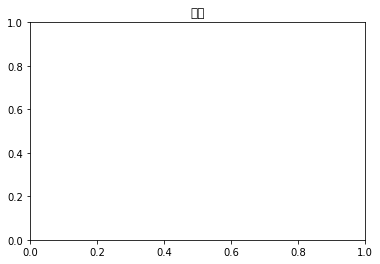

In [10]:
plt.title("中文")
plt.show()

显示不出中文是因为它找不到合适的字体去显示。

为此，我们可以使用`FontProperties`指定字体的路径来生成一个字体对象，然后画图的时候指定字体。

我个人比较喜欢简单粗暴，所以都是直接找到字体文件，放在当前文件夹直接用，比如宋体：

In [11]:
from matplotlib.font_manager import FontProperties
font_song = FontProperties(fname="SIMSUN.TTC")

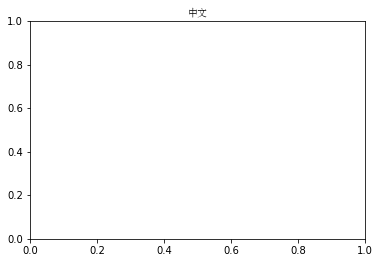

In [12]:
plt.title("中文", fontproperties=font_song)
plt.show()

### 菜系统计

In [13]:
data_tps = [s["菜系"] for s in data]

先看看有哪些菜系和数目，计数这种任务交给Counter就好了：

In [14]:
from collections import Counter

tps_cts = Counter(data_tps)

for k, v in tps_cts.items():
    print k, v

沪菜 87
浙江菜 1114
韩国 310
湘菜 75
江苏菜 249
满汉全席 44
微波炉菜 85
日本料理 11
海派菜 19
鲁菜 285
川菜 352
全部 1323
云南菜 18
淮阳菜 34
东北菜 52
闽菜 114
法国名菜 53
京菜 123
粤菜 195
其他西餐 34


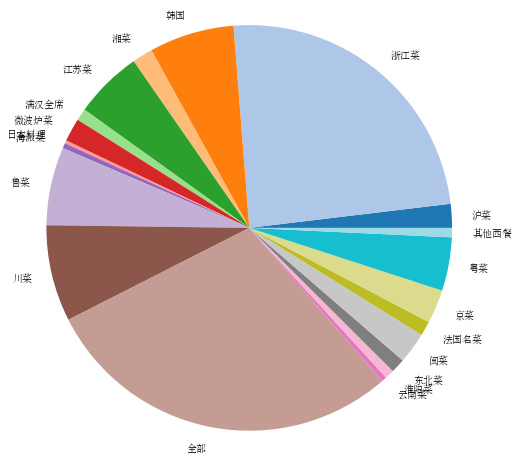

In [15]:
from matplotlib import cm

_, ax = plt.subplots(figsize=(8, 8))
ax.pie([v for k, v in tps_cts.items()], labels=[k for k, v in tps_cts.items()], colors=cm.Vega20.colors)
ax.axis("equal")
for t in ax.texts:
    t.set_font_properties(font_song)

plt.show()

这里，类别为全部大概是没有菜系的意思吧（我猜的）。

### 食材统计

食材统计是个比较麻烦的事情，先随便看看食材的数据长什么样子：

In [16]:
for i in range(0, 4000, 400):
    print data[i]["原料"]

活雌鸡或阉鸡1只，约重1500～2000克，菜油（或化猪油）100克，豆瓣25克，老姜50克，大葱10克，白糖或冰糖25克，花椒、料酒、酱油、精盐、味精、八角等适量。
燕窝（40克）、椰子（1个，750克）、味粉（15克）、鸡汤（250克）、精盐（少许）、小苏打粉（少许）
活鳝鱼350克。虾仁50克、熟火腿20克、猪腰片50克、水发冬菇20克，水发虾米10克、熟笋片30克…虾子5克。猪肉汤750克、绍酒15克、葱15克、姜7.5克、盐5克、味精3克、白胡椒粉1.5克。
光鸭（1只，1500克左右）、葱段（20克）、姜片（20克）、桂皮（20克）、茴香（13克）、红米（8克）、黄酒、冰糖（130克）、白酱、盐、麻油
节瓜600克（约1斤），草菇50克（约1两半），虾仁100克（约2两半），蟹肉75克（约2两），蛋白1只，上汤400毫升，姜1片，葱1条。盐1茶匙，糖1/4茶匙，粟粉、酒各1茶匙，水1汤匙，胡椒粉少许。
嫩母鸡（约1．25公斤左右）1只，胡萝卜100克，芹菜50克，葱头10O克，精盐10克，香叶半片，胡椒6粒，鸡清汤250毫升，生菜油500（罕耗100克），奶油15克，鸡油15克，红白菜200克，酸黄瓜100克，鲜西红柿100克，纸花2个，萝卜花2个，生菜叶10克。
水发鱿鱼（325克）、京葱花（40克）、大蒜头片（10片）、黄酒（12.5克）、醋（少许）、盐（6克）、味精（少许）、酱瓜米（少许）、菱粉（45克）、清汤（150克）。
鲜鱿鱼肉12两（约480克），西芹一条。西芹调味料：盐1/8茶匙，麻油少许。鱿鱼调味料：盐1/4茶匙，胡椒粉少许。椒麻汁料：花椒粒1茶匙，姜茸2茶匙，青葱茸2汤匙，糖2/3茶匙，醋，麻油各1茶匙，生抽，开水各2汤匙。
原料：面条500克，菠菜或小白菜300克，青椒（甜）3个，榨菜25克。葱10克，蒜1头，酱油10克，香醋5克，精盐3克，味精2克，香油15克，高汤适量。
主料扁豆150克，鸡油50克。调料料酒25克，味精5克，湿淀粉15克，鸡汤150克。


为了搞定这些问题，我们可以想办法去掉里面的一些关键词，比如多少克，少许，越重以及标点符号：

In [17]:
def process_single_ingredient(line):
    # 标点符号替换为空格
    line = re.sub("[。，、/…~～：；:%]", " ", line) + " "
    line = re.sub("（[^（]*）", " ", line)
    # 阿拉伯数字替换为空格
    line = re.sub("\d+\S* ", " ", line)
    # 汉语数字替换为空格
    line = re.sub("[一二两三四五六七八九十几半]+\S* ", " ", line)
    # 关键词替换为空格
    for s in ["少许", "适量", "或", "等", "重", "约", 
              "各", "原料", "调味料", "主料", "辅料", "调料", "用料", "和", "及"]:
        line = re.sub(s, " ", line)
    # 字母替换为空格
    line = re.sub(" \w+ ", " ", line)
    line = re.sub(" +", " ", line).strip()
    return line

for i in range(0, 4000, 400):
    print process_single_ingredient(data[i]["原料"])

活雌鸡 阉鸡 菜油 豆瓣 老姜 大葱 白糖 冰糖 花椒 料酒 酱油 精盐 味精
燕窝 椰子 味粉 鸡汤 精盐 小苏打粉
活鳝鱼 虾仁 熟火腿 猪腰片 水发冬菇 水发虾米 熟笋片 虾子 猪肉汤 绍酒 葱 姜 盐 味精 白胡椒粉
光鸭 葱段 姜片 桂皮 茴香 红米 黄酒 冰糖 白酱 盐 麻油
节瓜 草菇 虾仁 蟹肉 蛋白 上汤 姜 葱 盐 糖 粟粉 酒 水 胡椒粉
嫩母鸡 胡萝卜 芹菜 葱头 精盐 香叶 胡椒 鸡清汤 生菜油 奶油 鸡油 红白菜 酸黄瓜 鲜西红柿 纸花 萝卜花 生菜叶
水发鱿鱼 京葱花 大蒜头片 黄酒 醋 盐 味精 酱瓜米 菱粉 清汤
鲜鱿鱼肉 西芹 西芹 盐 麻油 鱿鱼 盐 胡椒粉 椒麻汁料 花椒粒 姜茸 青葱茸 糖 醋 麻油 生抽 开水
面条 菠菜 小白菜 青椒 榨菜 葱 蒜 酱油 香醋 精盐 味精 香油 高汤
扁豆 鸡油 料酒 味精 湿淀粉 鸡汤


这样结果就看起来不错的样子了，我们来做一下统计：

In [18]:
data_ings = map(lambda x: process_single_ingredient(x["原料"]), data)
data_ings_all = " ".join(data_ings).split()

ings_cts = Counter(data_ings_all)

不出意外的话，排在前面的原料应该是各种调味品：

In [19]:
for k, v in ings_cts.items():
    if v > 200:
        print k, v

酱油 1288
花椒 252
鸡蛋清 299
鸡汤 399
料酒 1048
姜末 284
水淀粉 254
味精 2049
姜 799
麻油 351
香油 460
醋 434
绍酒 808
精盐 1520
胡椒粉 801
湿淀粉 619
白糖 1140
芝麻油 434
葱 948
盐 1452
植物油 274
油 277
鸡蛋 506
熟猪油 325
淀粉 387
葱段 237
清汤 280
猪油 225
黄酒 243
花生油 410
糖 401
面粉 261


### 食材预测

有了食材，我们可以按照那篇英文文章的想法，用一个食材预测的任务来得到食物的Embedding向量。

那篇文章的想法是，我们用菜谱中的每个食材，来预测菜谱中除他之外的其它食材。

我们现在的食材有：

In [20]:
len(ings_cts)

5598

我们现在去除那些只出现了次数比较少的食材：

In [21]:
for k in ings_cts.keys():
    if ings_cts[k] <= 5:
        ings_cts.pop(k)

剩下的有：

In [22]:
len(ings_cts)

737

然后将他们编号：

In [23]:
word_idx = {k: idx+1 for idx, k in enumerate(ings_cts)}
idx_word = {idx+1: k for idx, k in enumerate(ings_cts)}

接下来将数据id化：

In [24]:
data_ings_idx = map(lambda x: [word_idx.get(t, 0) for t in x.split()], data_ings) 

#### 模型构造

有了数据集，模型也就不难构造了：

这里，我们使用`keras`来构造我们的`Embedding`模型：

In [25]:
import keras

Using TensorFlow backend.


因为使用的是`tensorflow`的后端，而且是GPU版本的，我需要设置一下GPU选项，免得我的小程序什么都没做就吃掉所有的GPU显存（坑爹的tensorflow能不能不要认为这些卡都是我一个人在用！）：

In [26]:
import keras.backend as K

if K.backend() == "tensorflow":
    config = K.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = K.tf.Session(config=config)
    K.set_session(session)

模型其实很简单，我们先构造一个`N×D`的`Embedding`矩阵，其中`N`是我的食材数目，`D`是我需要的食材向量的维度，那么`N`种食材就对应与这`N`个`D`维向量了。

现在我们来构造这个模型：

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten
from keras.regularizers import l2

模型是个`Embedding`层加一个`sigmoid`输出的全连接层`Dense`，输入维度为1，代表食材的种类，输出长度为`N`，代表这个食材与其它食材相关的概率。

In [28]:
n_words = len(word_idx) + 1
model = Sequential()
model.add(Embedding(n_words, 50, input_length=1, activity_regularizer=l2(0.01)))
model.add(Flatten())
model.add(Dense(n_words, activation="sigmoid", activity_regularizer=l2(0.01)))

In [29]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

构造我们的训练集：

In [30]:
data_x = []
data_y = []

for ings_idxs in data_ings_idx:
    if len(ings_idxs) == 1:
        continue
    for idx in set(ings_idxs):
        y = np.zeros(n_words)
        data_x.append(idx)
        y[list(set(ings_idxs) - set([idx]))] = 1
        data_y.append(y)
        
data_x = np.array(data_x)
data_y = np.array(data_y)

rd_idx = np.arange(len(data_x))
np.random.shuffle(rd_idx)

训练模型：

In [31]:
hist = model.fit(data_x[rd_idx], data_y[rd_idx], validation_split=0.1, verbose=0, epochs=1)

epoch 1 completed
epoch 2 completed
epoch 3 completed
epoch 4 completed
epoch 5 completed


训练完成，我们拿到这些Embedding的向量：

In [32]:
emb = model.get_weights()[0]

In [33]:
emb.shape

(738, 50)

算个距离度量，并看看一些跟食材最接近的都是什么：

In [34]:
from scipy.spatial import distance

dist = distance.squareform(distance.pdist(emb, "cosine"))

print idx_word[np.argsort(dist[word_idx["盐"]])[1]]
print idx_word[np.argsort(dist[word_idx["鸡汤"]])[1]]
print idx_word[np.argsort(dist[word_idx["西红柿"]])[1]]

酱油
鸡蛋
高汤


看起来还是蛮有意思的，然而并看不出什么靠谱的结论。

### 菜系预测

我们也可以用我们的数据来进行菜系预测，比如想象成一个序列预测问题，用一个输入序列来预测最终的菜系，序列处理可以使用一个`RNN`，比如`LSTM`，`GRU`等，这里我们随便用一个：

In [35]:
from keras.layers import LSTM, GRU
from keras.preprocessing.sequence import pad_sequences

In [36]:
def process_rnn(line):
    # 标点符号
    line = re.sub("[。，、/…~～：；:%（）]", "", line)
    # 阿拉伯数字替换为空格
    line = re.sub("[\d\w]", "", line)
    return line

data_rnn = [process_rnn(i["原料"]) for i in data]

In [37]:
word_cts = Counter("".join(data_rnn))

In [38]:
for k, v in word_cts.items():
    if v == 1:
        word_cts.pop(k)
        
len(word_cts)

1105

In [39]:
word_idx = {k: idx+1 for idx, k in enumerate(word_cts)}
idx_word = {idx+1: k for idx, k in enumerate(word_cts)}

tps_idx = {k: idx for idx, k in enumerate(tps_cts)}
idx_tps = {idx: k for idx, k in enumerate(tps_cts)}

In [40]:
data_rnn_idx = map(lambda x: [word_idx.get(t, 0) for t in x], data_rnn)
data_tps_idx = np.array(map(lambda x: tps_idx[x], data_tps))

In [41]:
data_rnn_idx = np.array(pad_sequences(data_rnn_idx))

In [42]:
n_seq = len(data_rnn_idx[0])
n_words = len(word_idx) + 1
n_tps = len(tps_idx)

In [43]:
rnn_model = Sequential()
rnn_model.add(Embedding(n_words, 64, input_length=n_seq))
rnn_model.add(GRU(64))
rnn_model.add(Dense(128, activation="relu", name="feat"))
rnn_model.add(Dense(n_tps, activation="softmax"))

rnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [44]:
hist = rnn_model.fit(data_rnn_idx, data_tps_idx,
                     epochs=50, verbose=0)

准确率为：

In [45]:
hist.history["acc"][-1]

0.90364867817347605

我们现在把最后一层的特征拿出来：

In [46]:
from keras.models import Model
feat_model = Model(inputs=rnn_model.input, outputs=rnn_model.get_layer("feat").output)

In [47]:
data_feat = feat_model.predict(data_rnn_idx)

In [48]:
data_feat.shape

(4577, 128)

做一个TSNE降到2维：

In [49]:
from sklearn.manifold import TSNE

In [50]:
data_feat_vis = TSNE(n_components=2, init='pca').fit_transform(data_feat)

In [51]:
data_feat_vis.shape

(4577, 2)

可视化一下：

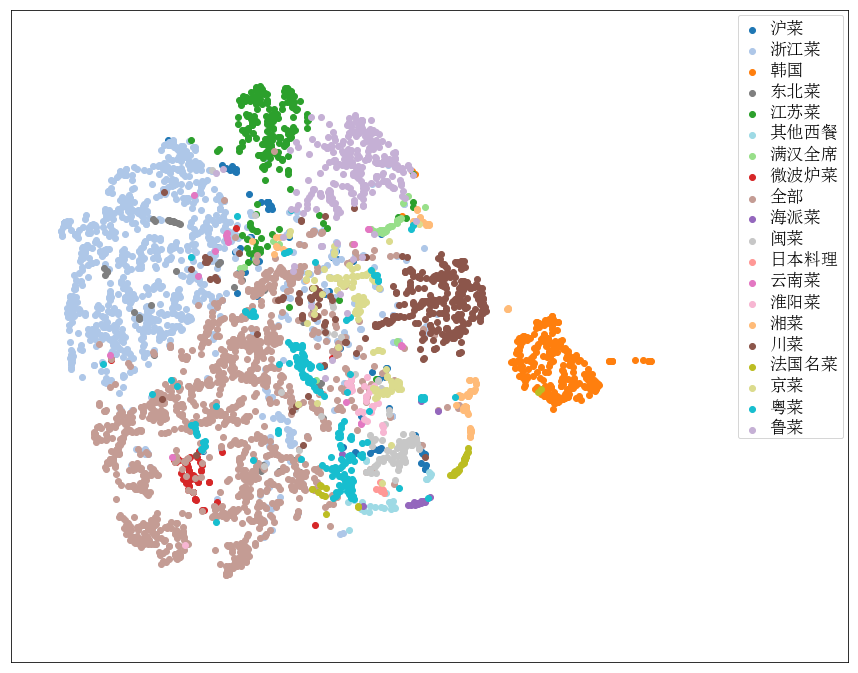

In [98]:
_, ax = plt.subplots(figsize=(15, 12))
for tp, idx in tps_idx.items():
    ax.scatter(data_feat_vis[data_tps_idx==idx, 0], data_feat_vis[data_tps_idx==idx, 1], 
               c=cm.Vega20.colors[idx], label=tp)

ax.set_xlim(-20, 40)
ax.set_ylim(-20, 20)
ax.set_xticks([])
ax.set_yticks([])

ax.legend(loc=0)
ltext = ax.get_legend().get_texts()
for t in ltext:
    t.set_font_properties(font_song)
    t.set_fontsize("xx-large")

plt.show()

- 韩国菜明显风格跟天朝有差异
- 浙江菜的隔壁是沪菜和江苏菜，江苏菜的隔壁是鲁菜
- 微波炉菜（不知道什么鬼）混入了全部菜系之中
- 闽菜和粤菜相邻
- 粤菜的点分布的还挺开的（大概广东人什么都吃？）
- 湘菜跟川菜也挺近的

剩下的请恕我老眼昏花看不清楚，从地理上看，还是有点意思的。

> 人生呐，就该一本正经地胡说八道。